In [1]:
import gdal, osr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import fiona

In [2]:
from matplotlib.colors import ListedColormap

In [3]:
class RasterProp:
    def __init__(self,
                 rasterFile,
                 sliceClass=None, slicing = False):
        self.raster = gdal.Open(rasterFile)
        self.geotransform = self.raster.GetGeoTransform()
        self.projRef      = self.raster.GetProjectionRef()
        self.originX = self.geotransform[0]
        self.originY = self.geotransform[3] 
        self.pixelWidth = self.geotransform[1] 
        self.pixelHeight = self.geotransform[5]
        
        if slicing:
            print('recomputing origin')
            x_ori_rel , y_ori_rel, xlen, ylen = sliceClass.relevantArea()
            self.originX, self.originY = pixel2coord(self.geotransform, 
                                                     x_ori_rel, 
                                                     y_ori_rel)
            
def array2raster(array, rasProp,newRasterfn):
    print('converting array to raster...')
    cols = array.shape[1]
    rows = array.shape[0]
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create( newRasterfn, 
                              cols, rows,
                              bands=1, 
                              eType= gdal.GDT_Float32)
    outRaster.SetGeoTransform((rasProp.originX, 
                               rasProp.pixelWidth, 
                               0, rasProp.originY, 
                               0, rasProp.pixelHeight))
    
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(rasProp.projRef)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [4]:
def raster2array(rasterfn):
    #print('converting raster to array...')
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

In [6]:
sloCost = raster2array(os.path.abspath('01_Data500/slope.tif'))
envCost = raster2array(os.path.abspath('01_Data500/fac_env.tif'))
infCost = raster2array(os.path.abspath('01_Data500/fac_inf.tif'))
pubCost = raster2array(os.path.abspath('01_Data500/fac_pub.tif'))
allCost = (ecoCost+envCost+infCost+pubCost)/4

# Select DC and path_based_on

In [6]:
dc ='dc5'
path_based_on = 'all'
pathFile = os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'

In [36]:
factors = ['eco','env','inf','pub', 'all']

In [37]:
lines = ['dc1','dc2','dc3','dc4','dc5']

In [5]:
def line_path(path_based_on, dc):
    pathFl =  os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'
    return raster2array(pathFl)

In [35]:
colors = ['#2980b9','#27ae60','#dc7633', '#a569bd','#34495e']
cmap = ListedColormap(colors)

# Line Length

In [7]:
def lineLength(lineArray):
    indicies = np.nonzero(lineArray)
    indicies_paired = np.stack((indicies[0],indicies[1]), axis=-1)
    disTot = 0
    for point in range(1,len(indicies_paired)-1,1):
        x1 = indicies_paired[point-1][0]
        y1 = indicies_paired[point-1][1]
        x2 = indicies_paired[point][0]
        y2 = indicies_paired[point][1]
        dist = np.sqrt((x2-x1)**2+(y2-y1)**2)*0.5
        disTot = disTot+dist
    return disTot

In [8]:
def lineLength_2(lineIdx):
    indicies_paired = np.transpose(lineIdx)
    disTot = 0
    for point in range(1,len(indicies_paired)-1,1):
        x1 = indicies_paired[point-1][0]
        y1 = indicies_paired[point-1][1]
        x2 = indicies_paired[point][0]
        y2 = indicies_paired[point][1]
        dist = np.sqrt((x2-x1)**2+(y2-y1)**2)*0.5
        disTot = disTot+dist
    return int(disTot)

In [65]:
allLineLenghts = []
for line in lines:
    for factor in factors:
        print(line, factor)
        lineLen = lineLength(line_path(path_based_on=factor, dc=line))
        allLineLenghts.append([line, factor, lineLen])
lengths = pd.DataFrame(allLineLenghts)
lengths.columns=['dc','path_based_on','length']

dc1 eco
dc1 env
dc1 inf
dc1 pub
dc1 all
dc2 eco
dc2 env
dc2 inf
dc2 pub
dc2 all
dc3 eco
dc3 env
dc3 inf
dc3 pub
dc3 all
dc4 eco
dc4 env
dc4 inf
dc4 pub
dc4 all
dc5 eco
dc5 env
dc5 inf
dc5 pub
dc5 all


In [15]:
cost = lengths.copy()

In [16]:
lengths.head()

,dc,basedOn,length
0,dc1,eco,252.610173
1,dc1,env,270.109785
2,dc1,inf,297.256781
3,dc1,pub,276.012002
4,dc1,all,273.611994


In [17]:
cost['cost'] = lengths['length']*1.3

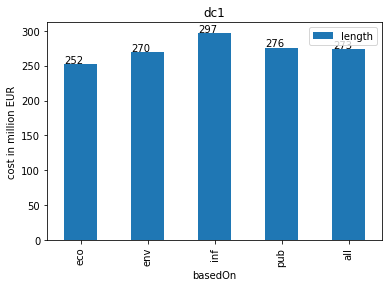

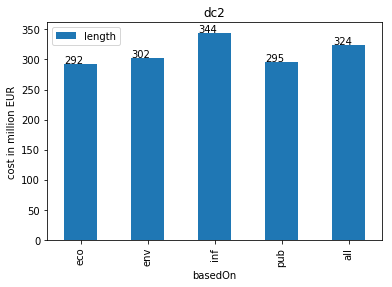

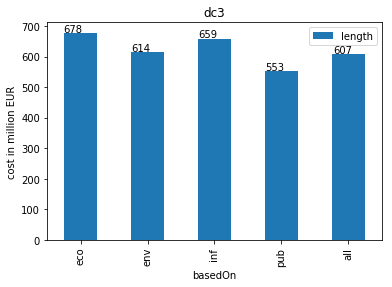

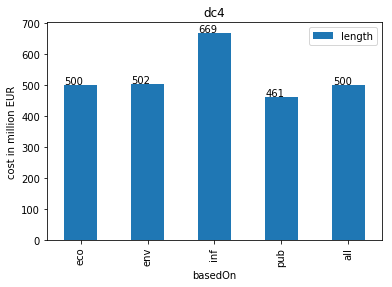

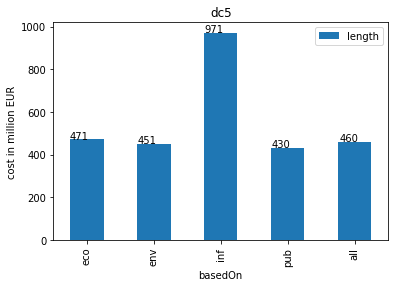

In [62]:
for line in lines:
    dcLine = lengths[['dc','path_based_on','length']].loc[lengths['dc']==line]
    ax = dcLine.set_index('basedOn').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylabel('cost in million EUR')
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+
                                   'length_'+line)))
    plt.show()

## Length through Protected zone

In [8]:
protZone = raster2array(os.path.abspath('01_Data500/protected.tif'))

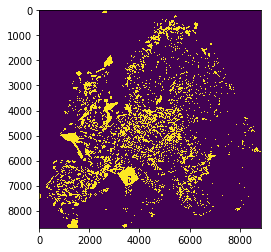

In [38]:
plt.imshow(protZone)

In [101]:
proCostAll = []
for line in lines:
    for factor in factors:
        linePath = line_path(path_based_on=factor, 
                             dc = line)
        proCost  = (np.multiply(protZone, linePath)/10).sum()
        #proLenthPass = lineLength(proCost)
        proCostAll.append([factor,line,proCost])

In [102]:
proCostAllDC = pd.DataFrame(proCostAll,
                           columns=['path_based_on',
                                   'dc','protZoneLength'])

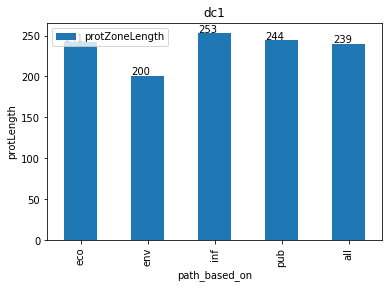

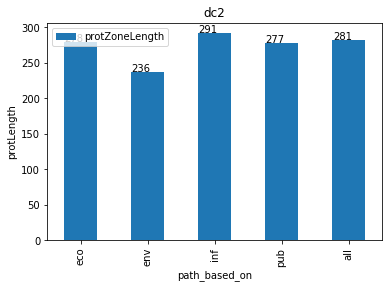

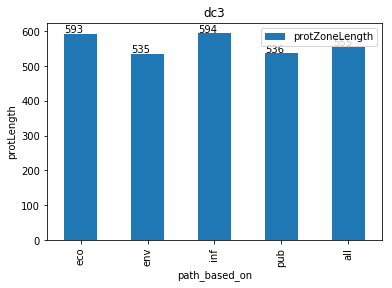

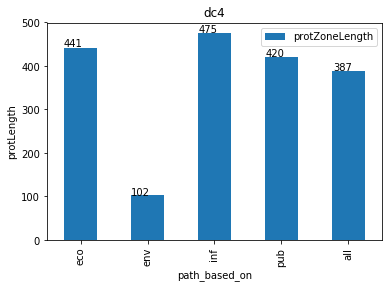

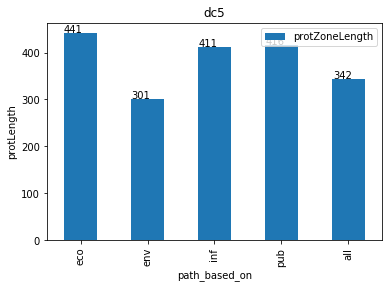

In [61]:
for line in lines:
    dcLine = proCostAllDC[['dc','path_based_on','protZoneLength']].loc[lengths['dc']==line]
    ax = dcLine.set_index('path_based_on').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylabel('protLength')
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+
                                   'protLength_'+line)))
    plt.show()

In [103]:
dc_lengthPro = lengths.set_index(['dc','path_based_on']).join(proCostAllDC.set_index(['dc','path_based_on']))

In [129]:
dc_lengthPro.columns=['Total line length','Through protected zone']

In [127]:
mpl.rcParams['axes.labelsize']=12
mpl.rcParams['ytick.major.size']=5
mpl.rcParams['ytick.major.size']=5
mpl.rcParams['legend.fontsize'] = 10

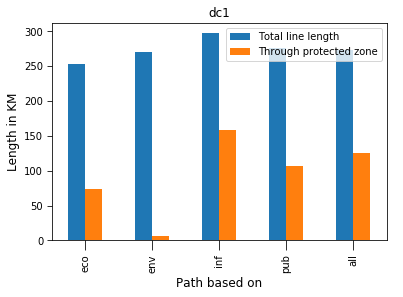

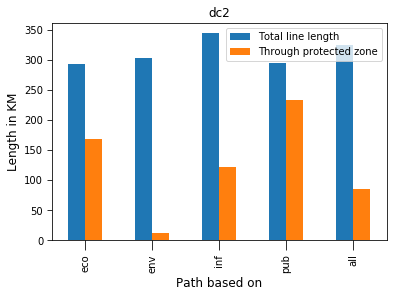

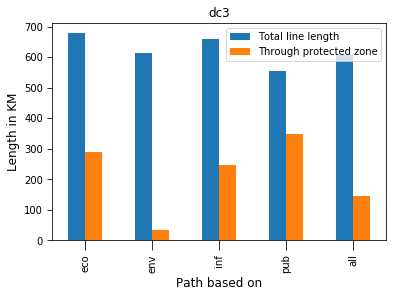

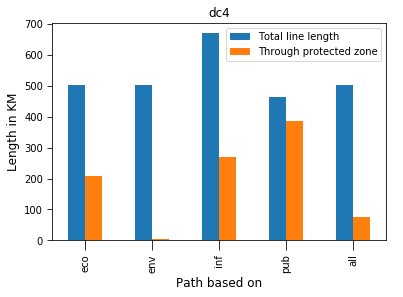

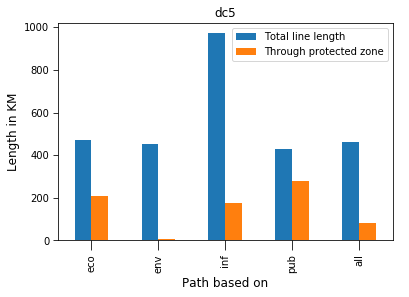

In [133]:
for line in lines:
    lineLenghts = dc_lengthPro.xs(line).plot(kind='bar')
    lineLenghts.plot(kind='bar')
    plt.title(line)
    plt.ylabel('Length in KM')
    plt.xlabel('Path based on')
    plt.savefig(os.path.abspath(
        str('02_DC_Projects_DE/01_graphs/lengthProt_'+line+'.pdf')),
               bbox_inches='tight')

# Population Affected

In [9]:
popu = raster2array(os.path.abspath('01_Data500/population.tif'))
def peopleAff(line):
    return popu[line[0],line[1]].sum()

In [10]:
def peopleAffected(line, basedOn):
    path = line_path(path_based_on=basedOn, dc = line)
    return np.multiply(popu,path).sum()

In [11]:
peopleAffectedAll = []
for line in lines:
    for factor in factors:
        print(line, factor)
        peopleAff = peopleAffected(line, factor)
        peopleAffectedAll.append([line,factor, peopleAff])

peopleAff = pd.DataFrame(peopleAffectedAll)
peopleAff.columns=['dc','basedOn','peopleAffected']

NameError: name 'lines' is not defined

In [93]:
from matplotlib.ticker import FuncFormatter

In [96]:
peopleAff['peopleAffected'] = peopleAff['peopleAffected']/1000

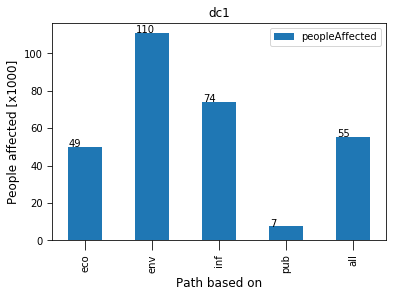

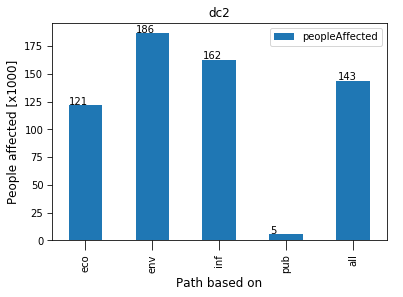

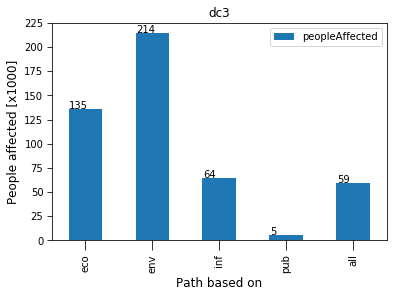

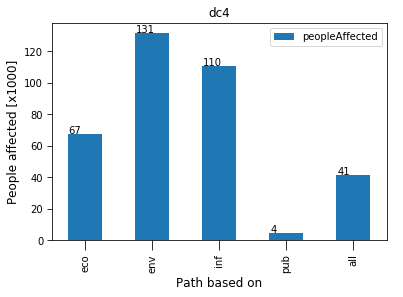

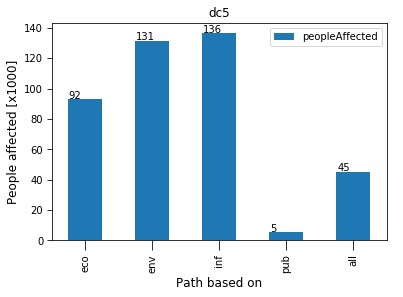

In [226]:
for line in lines:
    dcLine = peopleAff.loc[lengths['dc']==line]
    ax = dcLine.set_index('basedOn').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    
    plt.ylabel('People affected [x1000]', size=12)
    plt.xlabel('Path based on', size=12)
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+
                                   'peopleAff_'+line+'.pdf')),
               bbox_inches='tight')
    plt.show()

# Costs Based on renders 

In [80]:
def getCosts(path_based_on, dc):
    linePath = line_path(path_based_on=path_based_on, dc = dc)
    ecoCostLine = np.multiply(ecoCost, linePath).sum()
    envCostLine = np.multiply(envCost, linePath).sum()
    infCostLine = np.multiply(infCost, linePath).sum()
    pubCostLine = np.multiply(pubCost, linePath).sum()
    allCostLine = np.multiply(allCost, linePath).sum()
    return [ecoCostLine, envCostLine, infCostLine, pubCostLine, allCostLine]

In [32]:
def allCosts(line):
    cost = []
    for factor in factors:
        print(factor)
        facCost = getCosts(path_based_on=factor, dc=line)
        cost.append(facCost)
    allCost = pd.DataFrame(cost)
    allCost.columns=['eco','env','inf','pub','all']
    allCost['path_on'] = ['p_eco','p_env','p_inf','p_pub','p_all']
    return allCost.set_index('path_on')

In [231]:
def costGraph(data, title):
    data.plot(kind='bar',cmap=cmap)
    plt.title(title)
    plt.ylabel('Number of cells')
    plt.xlabel('Path based on')
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+title+'.pdf')),
               bbox_inches='tight')
    plt.show()
    
    

def costDiffGraph(data, title):
    data.sub(data.xs('p_all'),axis=1).plot(kind='bar',cmap=cmap)
    plt.title(title)
    plt.ylabel('Number of Cells \n (diff to all)')
    plt.xlabel('Path based on')
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+title+'.pdf')),
               bbox_inches='tight')
    plt.show()
    

    
def costDiffNormGraph(data, title):
    data.sub(data.xs('p_all'), axis=1).div(data.xs('p_all'),axis=1).plot(kind='bar', cmap=cmap)
    plt.title(title)
    plt.ylabel('Number of cells \n (frac diff to all)')
    plt.xlabel('Path based on')
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+title+'.pdf')),
               bbox_inches='tight')
    plt.show()
    

eco
env
inf
pub
all


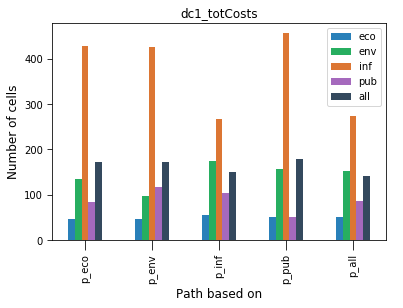

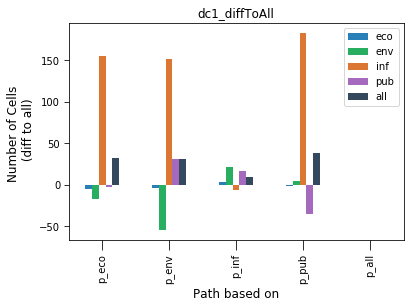

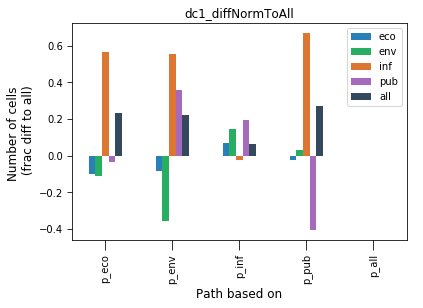

eco
env
inf
pub
all


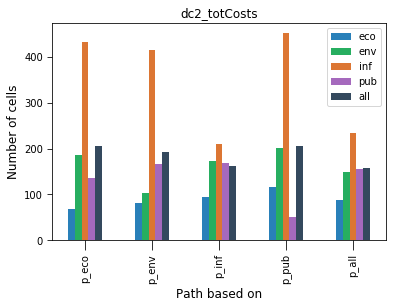

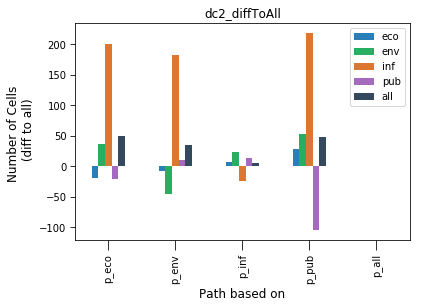

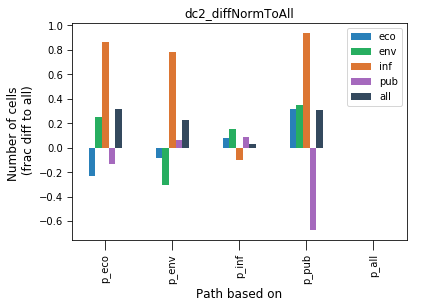

eco
env
inf
pub
all


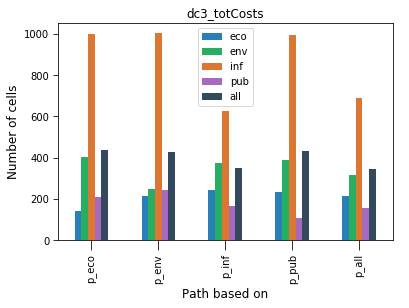

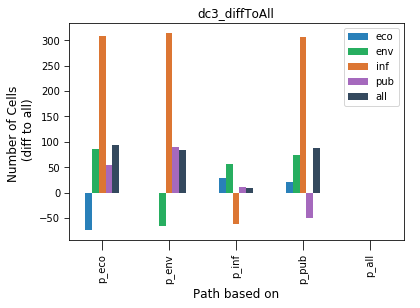

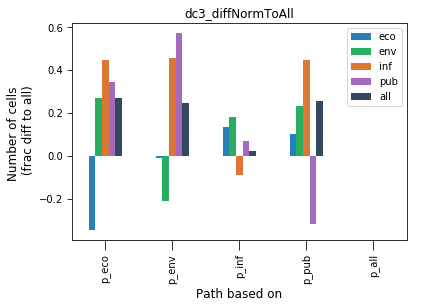

eco
env
inf
pub
all


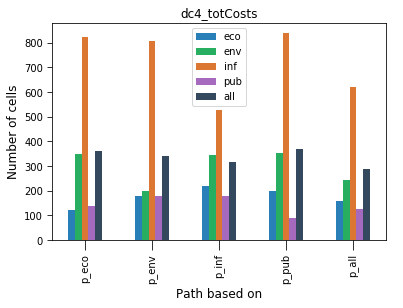

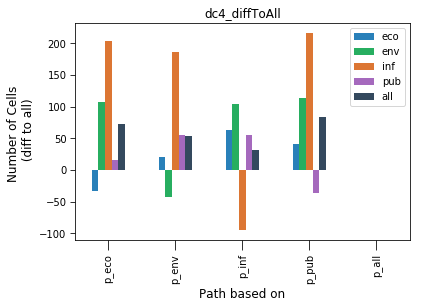

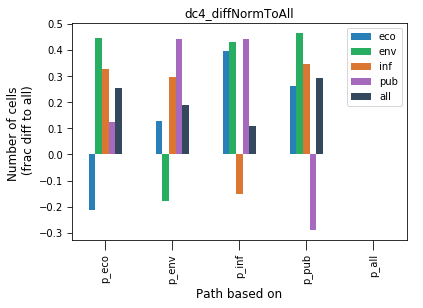

eco
env
inf
pub
all


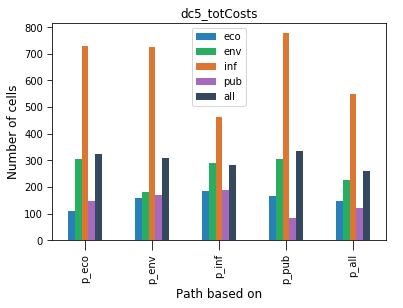

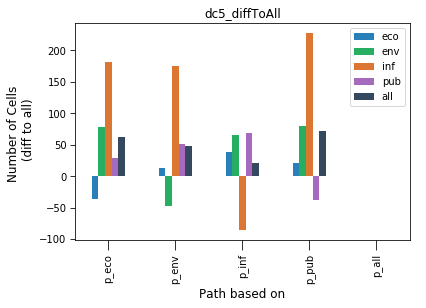

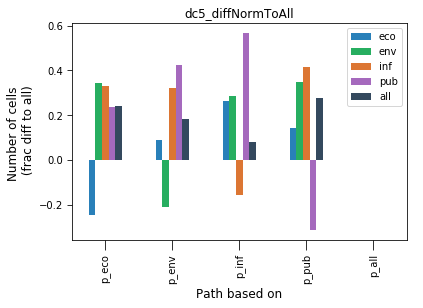

In [232]:
for line in lines:
    lineCosts = allCosts(line)
    costGraph(lineCosts, str(line+'_totCosts'))
    costDiffGraph(lineCosts, str(line+'_diffToAll'))
    costDiffNormGraph(lineCosts, str(line+'_diffNormToAll'))

## Corine

In [137]:
corOrig = os.path.abspath('01_Data500/corine_500_original_classification.tif')

In [139]:
landOrig = raster2array(corOrig)

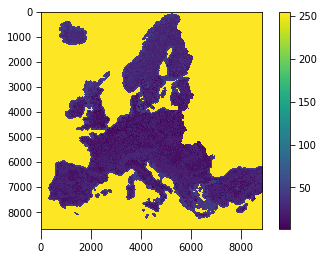

In [142]:
plt.imshow(landOrig)
plt.colorbar()

In [ ]:
corClas = pd.read_csv('Corine_Classification.csv', delimiter=';')[['CLC','Class_name']]

In [53]:
def corineClassPath(factor, line):
    dc1EcoPath = line_path(path_based_on=factor,dc=line)
    dc1EcoCor = np.multiply(dc1EcoPath,landOrig)
    value, counts = np.unique(dc1EcoCor, return_counts=True)
    corPath = pd.DataFrame([value,counts]).T
    corPath.columns =['CLC','count']
    corClasPath = corPath.set_index('CLC').join(corClas.set_index('CLC'))
    corClasDef = corClasPath.dropna().groupby('Class_name').sum()
    corClasDef.columns = [factor]
    return corClasDef

In [52]:
def getCorineClass(line):
    dc1Eco = corineClassPath(factor='eco',line=line)
    dc1Env = corineClassPath(factor='env',line=line)
    dc1Inf = corineClassPath(factor='inf',line=line)
    dc1Pub = corineClassPath(factor='pub',line=line)
    dc1All = corineClassPath(factor='all',line=line)
    dc1CorFac = dc1Eco.join(dc1Env, 
                            how='outer').join(dc1Inf,
                                             how='outer').join(dc1Pub, how='outer').join(dc1All, how='outer')
    return dc1CorFac

In [208]:
corDC1 = getCorineClass('dc1')
corDC2 = getCorineClass('dc2')
corDC3 = getCorineClass('dc3')
corDC4 = getCorineClass('dc4')
corDC5 = getCorineClass('dc5')

In [216]:
corDC1/corDC1.sum(axis=0)

,eco,env,inf,pub,all
Class_name,,,,,
Agriculture,0.704348,0.531317,0.624490,0.850526,0.698514
Forest,0.069565,0.012959,0.193878,0.052632,0.131635
HVN,0.056522,0.010799,0.012245,0.077895,0.036093
Man-Made,0.169565,0.444924,0.169388,0.018947,0.133758


In [13]:
def plotCorine(data, title, normalised=False):
    yLab = 'number of Cells'
    if normalised:
        data = data/data.sum(axis=0)
        yLab = 'fraction of cells'
    data.T.plot(kind='bar', stacked=True,title=title)
    plt.ylabel(yLab)
    plt.xlabel('path based on')
    plt.savefig(os.path.abspath(str('02_DC_Projects_DE/01_graphs/'+'corClasCostNorm_'+title+'.pdf')))
    plt.show()

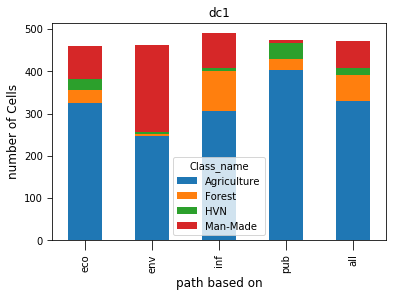

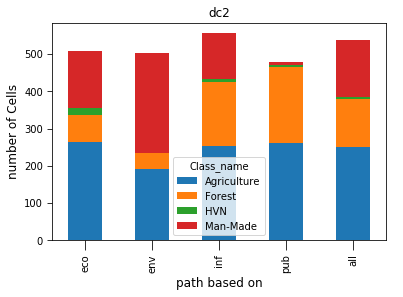

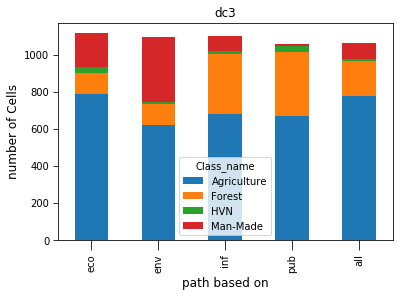

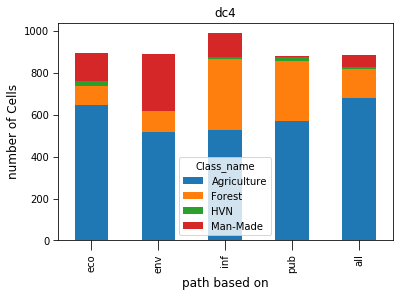

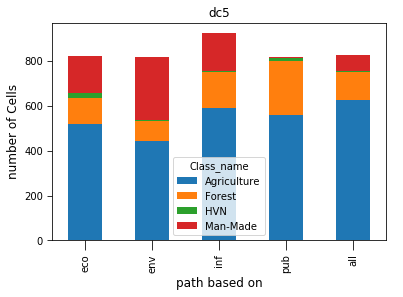

In [239]:
plotCorine(corDC1,'dc1')
plotCorine(corDC2,'dc2')
plotCorine(corDC3,'dc3')
plotCorine(corDC4,'dc4')
plotCorine(corDC5,'dc5')

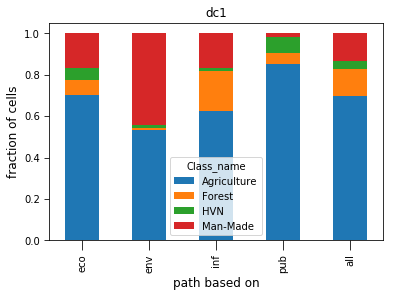

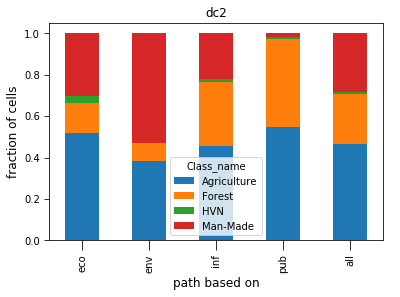

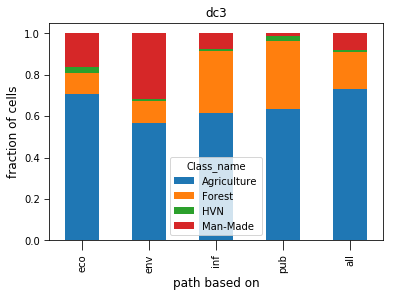

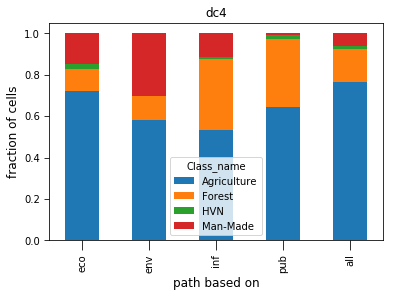

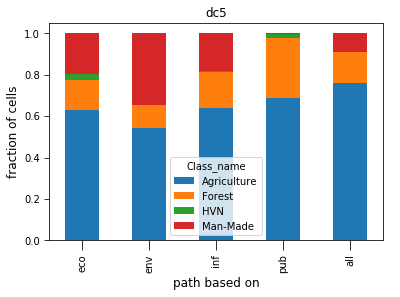

In [241]:
plotCorine(corDC1,'dc1', normalised=True)
plotCorine(corDC2,'dc2', normalised=True)
plotCorine(corDC3,'dc3', normalised=True)
plotCorine(corDC4,'dc4', normalised=True)
plotCorine(corDC5,'dc5', normalised=True)

## 'Similarness' of the path

### Area between the two lines

In [12]:
def getNumCellsBetween(line1,line2):
    combinedLine = line1+line2
    y,x = np.where(combinedLine!=0)
    
    coordinates = pd.DataFrame(np.array((x,y)).T, columns=['x','y'])
    numCells = 0
    for y in coordinates['y']:
        xs = (coordinates.loc[coordinates['y']==y])['x']
        lenth = max(xs)-min(xs)
        numCells = numCells+lenth
    #remove line area , add common area     
    return numCells

In [8]:
dc5_all = raster2array(os.path.abspath('01_Data500/out/all_dc5.tif'))
dc5_env = raster2array(os.path.abspath('01_Data500/out/env_dc5.tif'))
dc5_inf = raster2array(os.path.abspath('01_Data500/out/inf_dc5.tif'))
dc5_pub = raster2array(os.path.abspath('01_Data500/out/pub_dc5.tif'))
dc5_eco = raster2array(os.path.abspath('01_Data500/out/eco_dc5.tif'))

In [54]:
print(getNumCellsBetween(dc5_all,dc5_all))
print(getNumCellsBetween(dc5_all,dc5_env))
print(getNumCellsBetween(dc5_all,dc5_inf))
print(getNumCellsBetween(dc5_all,dc5_pub))
print(getNumCellsBetween(dc5_all,dc5_eco))

19444
182824
25735
66199


## Buffer Intersection

**Approch**

Create a buffer of 1.5KM (randomly choosen number) and calculating the fraction of intersection of the two buffer zones.

**Method**

*Step1:* Select cell indexes with path (non-zero values with path array). A list of tuples is created containing the path

*Step2:* Add the buffer tuples to the list of tuples. Here it is possible to change the buffer zone. This will add multiple tuples with same values. Hence, important to select only unique tuples. This is done with the set operator. 

*Step3:* Count the number of tuples common in the paths been compared

*Step4:* Normalize with the number of cells in the buffer zone of the normalized path. 



In [13]:
def getBuffPathLocations(line, bufferLength=3):
    y,x = line[0], line[1]
    orgList = list(zip(x,y))
    bufList = []
    for item in orgList:
        for shift in range(0,bufferLength,1):
            bufList.append((item[0]-shift,item[1]))
            bufList.append((item[0]+shift,item[1]))
            bufList.append((item[0]      ,item[1]-shift))
            bufList.append((item[0]      ,item[1]+shift))

            bufList.append((item[0]-shift,item[1]-shift))
            bufList.append((item[0]+shift,item[1]+shift))

            bufList.append((item[0]-shift,item[1]+shift))
            bufList.append((item[0]+shift,item[1]-shift)) 
    return set(bufList)


def getIntersection(bufRef, bufList2):
    intLen = len(bufRef.intersection(bufList2))
    return intLen/len(bufRef)

In [18]:
l111P = os.path.abspath('02_DC_Projects_DE/02_dc5_paths/eip_111.npy')

In [19]:
l111 = np.load(l111P)
#l1113 = np.load(l1113P)

In [11]:
getIntersection(getBuffPathLocations(l1111),
                getBuffPathLocations(l1113))

0.6105623866156017

## ProtectedZone length

In [14]:
prot = raster2array(os.path.abspath('01_Data500/protected.tif'))

In [15]:
def getProtectedCells(line):
    return prot[line[0],line[1]].sum()/10
#getProtectedCells(l1113)

## Slope Classification

In [50]:
def returnSlopeClass(line):
    slopVals = sloCost[line[0],line[1]]
    slopValsCount = np.unique(np.digitize(slopVals, [1.146,4.574]), return_counts=True)[1]
    return list(slopValsCount)

## Corine Classification

In [69]:
corOrig = raster2array(os.path.abspath('01_Data500/corine_500_original_classification.tif'))
def getCorineCLC(line):
    clcCode, clcCounts = np.unique(corOrig[line[0],line[1]], return_counts=True)
    return dict(zip(clcCode, clcCounts))
 
corClass = pd.read_excel('Corine_Classification.xlsx').set_index('CLC')

# AllPaths

In [75]:
peopleAffected = []
protZonePassed = []
lineLength     = []
buffInter_1111 = []
slopeClassData = []
corineCLCCount = []
for env in range(0,11,1):
    for inf in range(0,11,1):
        for pub in range(0,11,1):
            if (env==inf==pub==0):
                break;
            fileName = str(env)+str(inf)+str(pub)
            comName = os.path.abspath('02_DC_Projects_DE/02_dc5_paths/eip_'+fileName+'.npy')
            path = np.load(comName)
            
            corCLC = getCorineCLC(path)
            corineCLCCount.append([env/(env+inf+pub),
                                   inf/(env+inf+pub),
                                   pub/(env+inf+pub),corCLC])
            
#            slopClass = list(np.append(np.array([env, inf, pub]), returnSlopeClass(path)))
#            slopeClassData.append(slopClass)
            
#            linPplAff = peopleAff(path)
#            protZnLin = getProtectedCells(path)
#            lineLen = lineLength_2(path)
                
#            refBuff = getBuffPathLocations(l111)
#            buffInt = getIntersection(refBuff,
#                                      getBuffPathLocations(path))

#            buffInter_1111.append([env/(env+inf+pub),
#                                   inf/(env+inf+pub),
#                                   pub/(env+inf+pub),buffInt])
#            peopleAffected.append([env/(env+inf+pub),
#                                       inf/(env+inf+pub),
#                                       pub/(env+inf+pub),linPplAff])
#            protZonePassed.append([env/(env+inf+pub),
#                                       inf/(env+inf+pub),
#                                       pub/(env+inf+pub),protZnLin])
#            lineLength.append([env/(env+inf+pub),
#                                       inf/(env+inf+pub),
#                                       pub/(env+inf+pub),lineLen])

In [36]:
dc5Buffeip111 = pd.DataFrame(buffInter_1111, 
                columns=['env','inf','pub','buf_1111'])
dc5Buffeip111.to_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_buff.xlsx'))

In [37]:
dc5PplAffe = pd.DataFrame(peopleAffected, 
                         columns=['env','inf','pub','peopleAff'])
dc5PplAffe.to_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_peopleAffected.xlsx'))


dc5Protzon = pd.DataFrame(protZonePassed, 
                         columns=['env','inf','pub','protZoneCells'])
dc5Protzon.to_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_protZoneCells.xlsx'))


dc5Lengths = pd.DataFrame(lineLength, 
                         columns=['env','inf','pub','dc5Length'])
dc5Lengths.to_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_length.xlsx'))

In [67]:
dc5SlopClass = pd.DataFrame(slopeClassData, columns={'env','inf','pub','low','med','high'})
dc5SlopClass.to_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_slopeClass.xlsx'))

In [78]:
dc5CLCCount = pd.DataFrame(corineCLCCount,
                          columns={'env','inf','pub','clc_count'} )
dc5CLCCount.to_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_clcCount.xlsx'))

## corine mapping to defined classes

In [82]:
corinClassification = []
for row in dc5CLCCount.iterrows():
    lineCounts = pd.DataFrame.from_dict(dict(row[1].clc_count), orient='index', columns=['clc_count'])
    corineClassNameCount = corClass.join(lineCounts).fillna(0)[['Class_name','clc_count']].groupby('Class_name').sum().T
    clasList = list(corineClassNameCount.values[0])
    clasList.extend([row[1].env, row[1].inf, row[1].pub])
   
    corinClassification.append(clasList)
   
columns = ['Agriculture', 'Forest', 'HVN', 'Man-Made', 'Wasteland','env', 'inf', 'pub']
 
corinClassDF = pd.DataFrame(corinClassification, columns=columns)
corinClassDF.to_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_corinClassification.xlsx'))